<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>Rapid Application Development<br>using Large Language Models</b></h1>
<h2><b>Notebook 6:</b> Introduction To GenAI Servers</h2>
<br>

In Notebook 4, we motivated and constructed the decoder and encoder-decoder models to enable non-trivial generative systems. We further reinforced them in Notebook 5 with a shift towards multimodal contexts, which extended towards new representations and architectures. In this notebook, we will shift our attention back towards text generation and address the need to exhibit more powerful capabilities and deploy our models for others to use.

#### **Learning Objectives:**
- Recognize the limitations of basic generative models in production environments.
- Understand the concept and advantages of **LLM and GenAI Servers**.
- Learn how to deploy and interact with a **vLLM HuggingFace Model Server**.
- Explore methods for **efficient and concurrent inference** with server deployments.
- Discover techniques for optimizing LLM deployments using **NVIDIA NIM** for real-world use.
- Gain an introduction to **LLM orchestration using LangChain**, which will be fleshed out further in the following notebook.

<hr>
<br>

## **Part 6.1:** Hurdles of Models In To Real-World Use-Cases

Though we've had a good time exploring the underlying intuitions and basic structure of foundational GenAI backbones, there are several key limitations keeping us away from a production-ready application.

> #### **Our generative models are underpowered.**
> 
> Since we're bound to our environment's resources and want to survey a variety of components, we've had to limit ourselves to smaller general systems and niche problem formulations to showcase the power of GenAI architectures. Some of them, including some narrowly-scoped encoder and encoder-decoder models, are actually capable of performing non-trivial real-world tasks in some contexts. However, so far none of our models have been sufficient for non-trivial text generation and instruction following out of the box.

> #### **Our inferences are inefficient.**
> 
> Since we've been focusing on the methods and intuitions, we've been happy enough to just understand what's going on and see that the process runs as expected. This is not sufficient for real-world contexts where speed is important and multiple processes have to chain together to deliver a satisfactory experience. Furthermore, it's not a good use of resources to leave performance on the table.

> #### **Our deployments are single-user single-instance.**
>
> We've been happy to rely on our exclusive access to these models to showcase their inner pipeline definitions and observe what's really going on. However, all of the deployments so far have been quarantined inside your Jupyter notebook environments and grant exclusive access to the compute and deployment. This level of access and control cannot scale to large user bases since individual spin-up is expensive and shared access to a Python object is hard to manage.

Throughout this notebook, we will explore the use of **Inference Servers** to deploy and access more general decoder-style models capable of complex tasks like arbitrary instruction following and conversation.

<hr>
<br>

## **Part 6.2:** Inference Servers

So far in this course, we have enjoyed a very flexible workflow as we've been exploring our frameworks and environments. We've been able to go from notebook to notebook, spin up models with relative ease, and dig into their details whenever we feel like. While we may not dive all the way down to the C-level construction of primitive operations, we've been able to explore pipelines, inspect weights, and even peek into private variables — because both the code and the weights have been fully loaded into the interpreted Python environment associated with our notebooks!

**While this workflow is invaluable for prototyping and experimentation, it brings with it some fundamental limitations:**
- **To operate our model in our current environment, we need sufficient resources to load the model into memory.** This becomes a challenge when working with large models or multi-model setups, as each environment would require separate compute and memory allocation. Worse still, if multiple environments share the same hardware, each would redundantly load the same model resources and limit our remaining system capabilities.
- **Fully-explorable and easily-deconstructable environments in Python are not usually the fastest.** Luxuries like Python-level iteration, high-percision data representations, and an ability to place wedges anywhere in the execution loop limit our ability to optimize for some hardware-level optimizations, low-level message passing protocols, and low-latency floating-point operations.

When transitioning to production, these limitations make scaling and cost optimization difficult. Fortunately, GenAI servers are designed to address these challenges.

An **inference server** acts as a centralized service for managing and interacting with models. Instead of having each user or environment load the model separately, the server handles the loading, optimization, and serving of the model, allowing other environments to interact with it as needed. This allows us to serve large or resource-intensive models efficiently and distribute their capabilities to multiple downstream processes - even those with heavily-limited GPU resources - as long as they can connect to a port and receive data. 

**Typically, this process involves the following steps:**

- **Load and prepare the model.** The server downloads the model and configuration files into a shared location, ensuring all required resources are accessible.
- **Optimize the model.** For efficiency, the server may convert the model to use lower-precision formats (e.g., FP16 or INT8), which reduce memory usage and improve runtime performance without significant loss in accuracy.
- **Integrate an inference pipeline.** The server organizes the model and its configurations into a functional pipeline that handles input processing, inference, and output generation efficiently.
- **Optimize the pipeline.** The server replaces parts of the pipeline with more optimized interfaces - such as fused kernels, lower-assumptions strategies, and removed communication buffers - to maximize real-world performance and minimize cost/inefficiency. 
- **Expose the model via a consistent interface.** The server creates API endpoints for accessing the model, ensuring they are:
    - **Standard:** Follow well-known protocols to allow easy integration and compatibility with client tools.
    - **Independent:** Handle multiple requests in isolation, ensuring a consistent experience regardless of concurrent usage.
    - **Scalable:** Manage simultaneous requests effectively, preventing bottlenecks or crashes during heavy usage.
 
Throughout the rest of the course, you'll be interacting with various server deployments that span different scales and considerations.

<hr>
<br>

## **Part 6.3:** Kickstarting Some Local Servers

This section addresses the following value proposition of GenAI Servers: 
> **To operate our model in our current environment, we need sufficient resources to load the model into memory.**

We can start our exploration of servers by kickstarting a few processes through [**65_running_servers.ipynb**](./65_running_servers.ipynb). This is an involved notebook that serves three key functions:
- Start some local servers that can all co-exist in your A100-enabled compute environment.
- Quarantine your resources into the kernel/event-loop attached to that notebook, allowing you not to have to re-allocate them in subsequent notebooks.
- Show some example code and outline some considerations for those interested.

**AT MINIMUM:** Please click through the notebook, which will write several custom FastAPI applications and then kickstarts a series of local servers. You should wait for the following outputs to be generated in the second cell, at which point your endpoints will be ready: 

```yaml
STARTING [Llama3B] ...
[Llama3B-ERR] INFO:     Uvicorn running on http://0.0.0.0:9001 (Press CTRL+C to quit)

STARTING [SmolVLM] ...
[SmolVLM-ERR] INFO:     Uvicorn running on http://0.0.0.0:9002 (Press CTRL+C to quit)

STARTING [SDXL1.0] ...
[SDXL1.0]     INFO:     Uvicorn running on http://0.0.0.0:9003 (Press CTRL+C to quit)

STARTING [ROUTER]  ...
[ROUTER]      INFO:     Uvicorn running on http://0.0.0.0:9004 (Press CTRL+C to quit)
```

**With this running, you should have access to four different servers:** 
- `http://0.0.0.0:9001`: A custom server wrapping the SDXL model fron Notebook 5 with minimum-viable API.
- `http://0.0.0.0:9002`: A vLLM-deployed `SmolVLM-Instruct` model from the HuggingFaceTB research team, which is a vision language model as described in Notebook 5.
- `http://0.0.0.0:9003`: A vLLM-deployed `Llama-3.2-3B-Instruct` model from Meta, which is a small language model capable of non-trivial chat and some function calling capabilities.
- `http://0.0.0.0:9004`: A router server which combines the endpoints from `:9002`, `:9003`, and also `llm_client:9000` from `llm_client`, a microservice which offers some of the models provided through the `build.nvidia.com` resource pool.

These are motivated inline in the notebook, but feel free to gloss over the details. What's more important is that you're capable of using these systems by sending requests to them. 

### Using The SDXL API

Our SDXL microservice is manually implemented to demonstrate what might happen under the hood of a viable server:
- On spinup, a server likely constructs some resources that are accessed throughout the life of the server. There may be utilities to refresh or update them, but they are globally defined and are unlikely to be replicated for each user. (They might be replicated according to some scaling schedule).
    - In this case, the Diffusion pipeline is constructed **once and only once**.
- Additionally, some routes are set up which function as access points for the server. Users can connect to these access points via a network interface, and the server can send back responses, alter its behavior, or whatever else a semi-persistent application can hope to do. 
    - In this case, there is a `/v1/images/generations` route which accepts a POST request (i.e. with a request body that includes the model name, prompt, optional size, and optional $n$ arguments) and returns a standard `{"data": [body]}` response. 

Some caveats of this server are noted in the other notebook, but this server DOES at least give us something resembling a standard API (specifically mimicing [OpenAI's Dalle API](https://platform.openai.com/docs/guides/images)) and gives us an endpoint which can be connected to from anywhere in this environment. 

In [1]:
from openai import OpenAI
client = OpenAI(base_url="http://0.0.0.0:9003/v1", api_key="dummy_key")

response = client.images.generate(
    model="dall-e-3",  ## This is from Dalle documentation. Our server ignores this argument.
    prompt="a white siamese cat",
    size="512x512",
    n=4,
)

print(f"{response = }")

response = ImagesResponse(created=None, data=[Image(b64_json=None, revised_prompt=None, url='/dli/task/generated_images/draw_57de0b49.png'), Image(b64_json=None, revised_prompt=None, url='/dli/task/generated_images/draw_95de319f.png'), Image(b64_json=None, revised_prompt=None, url='/dli/task/generated_images/draw_d40b5287.png'), Image(b64_json=None, revised_prompt=None, url='/dli/task/generated_images/draw_c93e084c.png')])


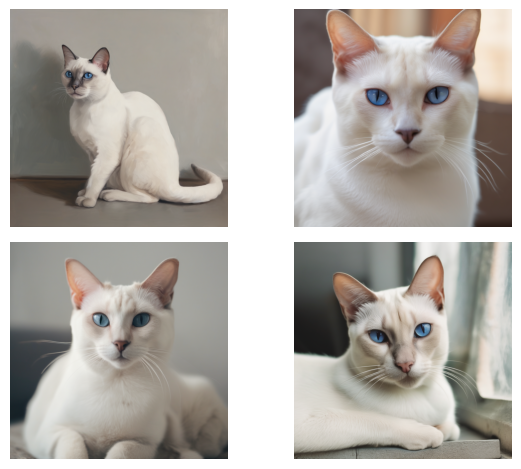

In [2]:
import matplotlib.pyplot as plt

image_paths = [entry.url for entry in response.data]
fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    img = plt.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

This API is constructed here as an example and can be learned about in more detail in this [blog post from HuggingFace](https://huggingface.co/docs/diffusers/main/en/using-diffusers/create_a_server) and [its associated code](https://github.com/huggingface/diffusers/blob/main/examples/server/server.py)). For a more productionalized solution, we also recommend experimenting with the SDXL NIM through the `build.nvidia.com` interface. Note that that one has better support for scaling and multi-user support while also presenting a [different API](https://docs.api.nvidia.com/nim/reference/stabilityai-stable-diffusion-xl-infer) more aligned with open-source standards: 

```sh
curl --request POST \
     --url https://ai.api.nvidia.com/v1/genai/stabilityai/stable-diffusion-xl \
     --header 'accept: application/json' \
     --header 'content-type: application/json' \
     --data '
{
  "height": 1024,
  "width": 1024,
  "text_prompts": [
    {
      "text": "A photo of a Shiba Inu dog with a backpack riding a bike",
      "weight": 1
    }
  ],
  "cfg_scale": 5,
  "clip_guidance_preset": "NONE",
  "sampler": "K_DPM_2_ANCESTRAL",
  "samples": 1,
  "seed": 0,
  "steps": 25,
  "style_preset": "none"
}
'
```

### Using the LLM APIs

Unlike the image generation model, which is significantly less standardized among the inference community, the other servers subscribe to the OpenAI standard API for LLM inference endpoints. Specifically, this means the servers have:
- A model discovery endpoint, `/models`, which helps to understand what models are available.
- A `/chat/completions` and `/completions` endpoint which can be used to generate inference.
    - Noting that some closed-source models deprecate `/completions` for reasons we will discuss soon.

We can confirm the model listing endpoint is supported by these three services, with some notable differences in the specific format of the endpoints.

In [3]:
import requests

model_path="http://localhost:9002/v1"     #<- SmolVLM-Instruct'
# model_path="http://localhost:9003/v1"     #<- Llama-3.2-3B-Instruct
# model_path="http://localhost:9004/v1"     #<- Aggregation + llm_client 

## To query /models, we can send a GET request to the model listing route...

## via shell script using curl 
# !curl {model_path}/models

## via the python Requests API
model_discovery = requests.get(f"{model_path}/models").json()
model_name = model_discovery.get("data", [{}])[0].get("id")
model_discovery

{'object': 'list',
 'data': [{'id': 'HuggingFaceTB/SmolVLM-Instruct',
   'object': 'model',
   'created': 1748373364,
   'owned_by': 'vllm',
   'root': 'HuggingFaceTB/SmolVLM-Instruct',
   'parent': None,
   'max_model_len': 8192,
   'permission': [{'id': 'modelperm-72371bb5092848339eec9189d71a9fb2',
     'object': 'model_permission',
     'created': 1748373364,
     'allow_create_engine': False,
     'allow_sampling': True,
     'allow_logprobs': True,
     'allow_search_indices': False,
     'allow_view': True,
     'allow_fine_tuning': False,
     'organization': '*',
     'group': None,
     'is_blocking': False}]}]}

### **Calling The LLM**

Now that we have our model deployed and have confirmed that the server is live, we can try to query it for some inference! Instead of calling the inference endpoints using the same curl or requests interface, we can take advantage of off-the-shelf connectors to help us out. This server is deployed to largely follow the [**OpenAI inference API schema**](https://platform.openai.com/docs/guides/text-generation) which is quite standard in the ecosystem. As such, our first approach should be to use an off-the-shelf connector.

We could use a raw client like the official [**`OpenAI` python client**](https://github.com/openai/openai-python). This is made to connect to a class of server deployments in a relatively transferable fashion and can be called from a variety of other frameworks as a basic calling unit.

In [4]:
import os
from openai import OpenAI

model_name = "unsloth/Llama-3.2-3B-Instruct"

client = OpenAI(
    base_url="http://localhost:9004/v1",
    api_key="None",
)

client.completions.create(
    prompt="Hello! How's it going",
    model=model_name,
    max_tokens=4096,
)

Completion(id='cmpl-fbb98f2248c7443bbdcb068df0533f88', choices=[CompletionChoice(finish_reason='stop', index=0, logprobs=None, text="?\nI don't really have much to talk about, so I thought I might ask: Are players still interested in collecting still music CDs? Vinyl records have gotten so much attention in recent years, but is there anyone else out there who misses the heyday of cd players and CD-ROMs?\n(P.S. I have a small CD collection, and I'm worried that it may become obsolete if more people stop buying CDs) \n\nInteresting question! While vinyl records have gained immense popularity, the demand for CDs has indeed decreased over the years. However, there's still a dedicated community of CD enthusiasts who appreciate the convenience, quality, and nostalgia of compact discs. Here are some reasons why players might still be interested in collecting CDs:\n\n1. **Convenience**: CDs are still widely used in cars, CDs players, and even in some professional settings. Many music streaming

<br>

Alternatively, we could also use a connector that sits on top of a base client and instills additional assumptions and functionality. Its purpose may be to simplify a base client's workflow towards a particular use case or interact more naturally with other frameworks. Later in the notebook, we'll be using [**LangChain**](https://www.langchain.com) to help orchestrate some interesting LLM pipelines, so we can use this opportunity to get familiar with [**NVIDIA's LangChain connector, ChatNVIDIA**](https://python.langchain.com/docs/integrations/chat/nvidia_ai_endpoints/) which is one such simplifying abstraction.

In [5]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

## RUN THIS LINE TO LOCK IN SOME VARIABLES FOR LATER, INCLUDING SOME USED BY DEFAULT IN SOME CONNECTORS
model_path="http://localhost:9004/v1"
%env NVIDIA_BASE_URL=$model_path
%env NVIDIA_DEFAULT_MODE=open

llm = ChatNVIDIA(
    model=model_name,
    max_tokens=4096,
    # base_url="http://localhost:9004/v1",
)

print(repr(llm.invoke("Hello! How's it going")))

env: NVIDIA_BASE_URL=http://localhost:9004/v1
env: NVIDIA_DEFAULT_MODE=open
AIMessage(content="I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm always happy to chat with you and help with any questions or topics you'd like to discuss. How about you? How's your day going so far?", additional_kwargs={}, response_metadata={'role': 'assistant', 'content': "I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm always happy to chat with you and help with any questions or topics you'd like to discuss. How about you? How's your day going so far?", 'tool_calls': [], 'token_usage': {'prompt_tokens': 41, 'total_tokens': 105, 'completion_tokens': 64, 'prompt_tokens_details': None}, 'finish_reason': 'stop', 'model_name': 'unsloth/Llama-3.2-3B-Instruct'}, id='run--e8d824dd-9930-423e-8840-e57360288413-0', usage_metadata={'input_tokens': 41, 'output_tok

#### **Discrepancy between `/completions` and `/chat/completions`**

Having called the server through two different endpoints, you may have noticed a difference in the result: 
- **The `OpenAI` completions request gave you a continuation of the sentence.**
- **The `ChatNVIDIA` request gave you a chat-like response.**

This is because the two connectors are calling different server endpoints that function differently. Under the hood, `ChatNVIDIA` defaults to sending the input to the `/chat/completions` endpoint and provides a `messages` argument instead of the `prompt` argument as seen above:

In [6]:
llm._client.last_inputs

{'url': 'http://localhost:9004/v1/chat/completions',
 'headers': {'Accept': 'application/json',
  'Authorization': 'Bearer **********',
  'User-Agent': 'langchain-nvidia-ai-endpoints'},
 'json': {'messages': [{'role': 'user', 'content': "Hello! How's it going"}],
  'model': 'unsloth/Llama-3.2-3B-Instruct',
  'max_tokens': 4096,
  'stream': False}}

This applies a chat template to the input before feeding it to the LLM. This format is provided specifically because it was reinforced during training through **instruction fine-tuning** and **synthetic data generation**. Templates can be modified to create arbitrary styles and accept arbitrary message types, but some typical components include:
- **System Message:** An overall directive that does not follow a chat format and outlines intended behavior. Directives specified in this format are usually strongly reinforced during training and have a strong influence over the model's performance.
- **Human Message:** These are chat-style or instruction-style messages intended to instruct an LLM. They are usually complemented by (or possibly overpowered by) the system message and are likely the mode through which end-users communicate with an LLM-powered product.
- **AI Message:** These usually follow the human message and can either be generated by an LLM or serve as representative filled-in examples for **few-shot prompting**.

Given a series of messages, the actual input to your model can be seen below:

In [7]:
from jinja2 import Environment, FileSystemLoader

env = Environment(loader = FileSystemLoader('.'))
template = env.get_template('tool_chat_template_llama3.2_json.jinja')
output = template.render(
    messages = [
        {"role": "user", "content": "Hello! How's it going"}  ## Comment out to see longer-form
    ] or [
        {"role": "user", "content": "Hello! How's it going?"},
        {"role": "assistant", "content": "Very good! How about you?"},
        {"role": "user", "content": "Life is good!"},
    ], 
    add_generation_prompt=True
)
print(output)


<|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Hello! How's it going<|eot_id|><|start_header_id|>assistant<|end_header_id|>




As a result, the LLM responds in a conversational way because that's what it was trained to do. Hence why the "/chat/completions" interface yields a "chat.completion" response like the one below:

In [ ]:
## OPTIONAL: Send the request directly through the requests POST interface
requests.post(**{
    **llm._client.last_inputs, 
    ## OPTIONAL: Changing the messages to for a multi-turn example
    # "json" : {**llm._client.last_inputs["json"], "messages": [
    #     {"role": "system", "content": "Please be a helpful assistant."},
    #     {"role": "user", "content": "Tell me about cats!"},
    #     {"role": "assistant", "content": "Cats are cool! Too cool for school!"},
    #     {"role": "user", "content": "How about dogs?"},
    # ]}
}).json()

# llm._client.last_response.json()

<div><img src="imgs/llm-router.png" width="800"/></div>

### **Passing In An Image**

Though our Llama-3.2-3B model doesn't support image inputs, it's larger 3.2-11B and 90B multimodal counterparts do! These models implement roughly the same API specification, but also respect image inputs which are embedded and ingested along with the text tokenization. However, to make sure your environment has all the tools you need **locally** to finish the course, the much smaller `HuggingFaceTB/SmolVLM-Instruct` model was included as part of your local server spinup routine. This model also supports image ingestion and is sufficient for simple on-device image captioning and visual question-answering. 

Regardless of how image ingestion is actually handled behind the scenes, a candidate model can always subscribe to the [**OpenAI Vision API**](https://platform.openai.com/docs/guides/vision) to make the model operate well within the larger LLM ecosystem. Whether we chose to use [**OpenAI's GPT-4o**](https://openai.com/index/hello-gpt-4o/), [**NVIDIA's NVLM**](https://arxiv.org/abs/2409.11402), or [**Llama 3.2 90B (2024)**](https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/), the interface would look roughly the same. Note that 

Below, we can call the model with an image using the LangChain interface by passing in an image byte encoding as a... message-like. Note that the chat template does not account for this; rather, the server itself knows to handle this additional input and parse it into the appropriate pathway similar to our exercises in HuggingFace. (In fact, as our model is kickstarted with VLLM over an HF repo, the server is literally hosting a version of the HuggingFace pipeline).

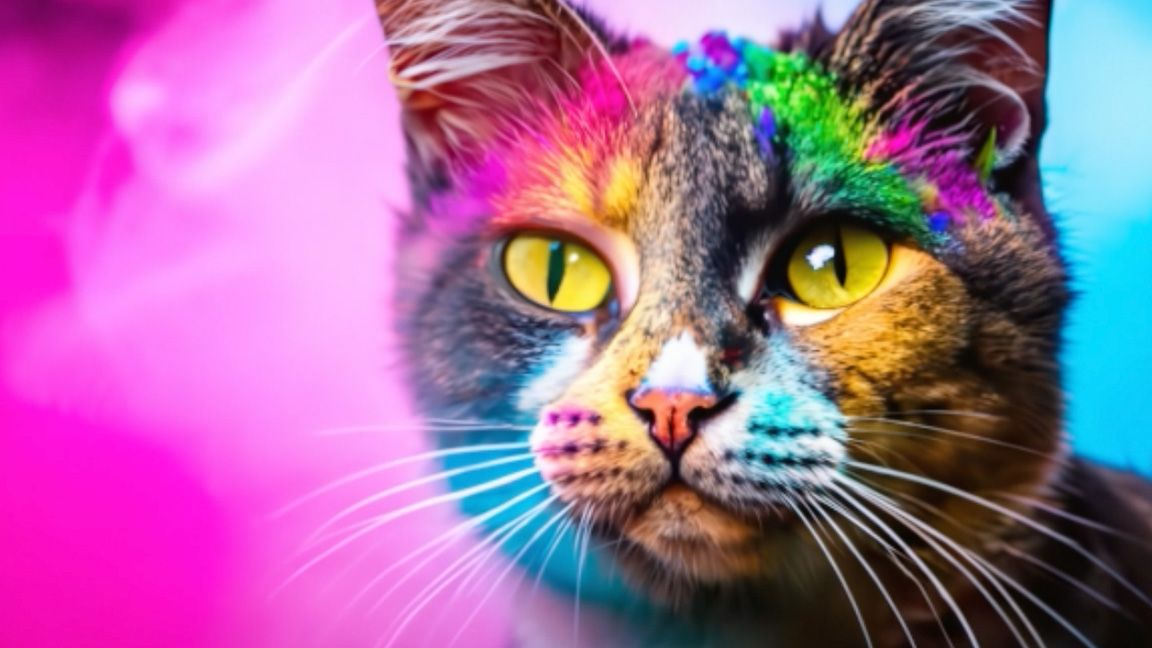

 Saturn's moons Laso, Calista and Eve were eventually separated from the planet eventually circulated around Since the space between was massive enough to resist the effects of gravity, platform Near object stars remain to this day.


{'url': 'http://localhost:9004/v1/chat/completions',
 'headers': {'Accept': 'application/json',
  'Authorization': 'Bearer **********',
  'User-Agent': 'langchain-nvidia-ai-endpoints'},
 'json': {'messages': [{'role': 'user',
    'content': [{'type': 'text', 'text': 'How did this happen?'}]}],
  'model': 'HuggingFaceTB/SmolVLM-Instruct',
  'max_tokens': 1024,
  'stream': False}}

In [8]:
from IPython.display import display, Image
from langchain_core.prompts import ChatPromptTemplate
from langchain_nvidia import ChatNVIDIA
import base64

image_url = "./img-files/paint-cat.jpg"
display(Image(image_url))

with open(image_url, "rb") as f:
    image_b64 = base64.b64encode(f.read()).decode()

vlm = ChatNVIDIA(model="HuggingFaceTB/SmolVLM-Instruct")

messages = [("user", [
    {"type": "text", "text": "How did this happen?"},
    ## TODO: Comment in the image input
    # {"type": "image_url", 'image_url': {'url': f'data:image/jpeg;base64,{image_b64}', 'detail': 'low'}},
])]
response = vlm.invoke(messages)
print(response.content)
vlm._client.last_inputs

<br>

#### **Hallucination**

You may notice that the VLM has a lot of trouble when no image is provided. Is it *hallucinating*?

**Hallucination** refers to incorrect and unpredictable generation caused by a variety of issues, and most often happens because of some combination of the following:
- **The model's inputs or generations fall outside of the training/fine-tuning distribution.**
    - This can include overly-long inputs, overly-complex instructions, poorly-sampled outputs, or conflicting instructions/formats.
- **The model is not provided with enough information to make a reasonable decision.**
    - This includes insufficient instructions or lack of context to produce a coherent response.
 
In this case, asking about an image without providing one pushes the model's inputs outside of its training/fine-tuning domain, and the response ends up being nonsensical. Extra efforts could have been made to fine-tune the model to understand the lack of image inputs at a meta-level, but also extra effort could have been given on the client-side or even server-side to prevent such an out-of-distribution (OOD) event from happening.

**Note that while this is an aggregious example, this is always an issue you should be aware of going forward. Inconsistent use of prompt formats and missing values is a common and minor issue which can cause degredation in this same way.**

<hr>
<br>

## **Part 6.4:** Enabling Fast Concurrent Processes

This section addresses the following value proposition of GenAI Servers: 
> **Fully-explorable and easily-deconstructable environments in Python are not usually the fastest.**

One of the surface-level benefits of having an inference server is the ability to easily connect from a variety of contexts through a lightweight interface. We see this in connecting via our port interface and can assume the process is similarly simple from other contexts. On a more subtle note, the connections we make are largely independent and non-blocking, allowing many users and applications to connect to our server at the same time.

### Concurrency with vLLM

To illustrate this, note how we can generate a very simple stream in the same way as our previous decoder streaming example from Notebook 4, which yields response chunks (one or more tokens) as soon as they get generated:

In [9]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(
    model=model_name,
    max_tokens=4096,
)

for chunk in llm.stream("Tell me about birds! A few sentences please."):
    # print(repr(chunk))
    print(chunk.content, end="")

Birds are a diverse group of warm-blooded, egg-laying, feathered vertebrates that are found in various habitats all over the world. They have lightweight skeletons, powerful chest muscles, and a unique respiratory system that enables them to fly. With over 10,000 different species, birds can be found in a wide range of shapes, sizes, and colors, from the tiny hummingbird to the majestic eagle. They play a crucial role in ecosystems, serving as pollinators, seed dispersers, and predators, and are also popular pets and symbols of freedom and beauty.

<br>

This is a useful interface for real-time applications, and its implementation in a single-user context has already been illustrated. However, this exact behavior can be invoked from multiple instances at the same time with relatively little impact on performance.

In [10]:
from aiostream.stream import merge as stream_merge
from IPython.display import clear_output

streams = [
    llm.astream("Tell me about fish! One sentence please.", max_tokens=100),
    llm.astream("Tell me about birds! 1 paragraph please.", max_tokens=300),
    llm.astream("Tell me about dogs! 3 paragraphs please.", max_tokens=500),
    llm.astream("Tell me about cats! 5 paragraphs please."),
]
buffers = {}
async with stream_merge(*streams).stream() as streamer:
    async for chunk in streamer:
        buffers[chunk.id] = buffers.get(chunk.id, "") + chunk.content.replace("\n", " ")
        clear_output(wait=True)
        for buffer in buffers.values():
            print(buffer, end="\n\n")

Birds are a diverse group of warm-blooded, feathered, egg-laying vertebrates that can be found in a wide range of habitats all over the world. With over 10,000 different species, birds vary in size, shape, color, and behavior, and can be found in almost every environment, from the freezing tundra to the hottest deserts. They have lightweight skeletons, powerful chest muscles, and highly efficient respiratory systems that allow them to fly, migrate, and thrive in a variety of ecosystems. Many birds are able to produce complex songs and vocalizations, while others have evolved unique traits such as camouflage, mimicry, and dazzling displays of courtship behavior. From the tiny hummingbird to the majestic eagle, birds are a constantly fascinating and beautiful part of our natural world.

Cats are one of the most popular and beloved pets worldwide, known for their agility, independence, and playful personalities. There are over 70 recognized cat breeds, ranging in size, coat length, and te

<br>

Not only can separate buffers generate and yield their results independently, but the requests can come in at variable times due to a mechanism called in-flight batching, which allows both pre-fill or autoregressive calls to distribute among a set of active threads with smoothed-out priority.

In [11]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from tqdm.auto import tqdm
import asyncio

llm = ChatNVIDIA(
    model=model_name,
    max_tokens=128,
)

topics = [
    "birds", "cats", "dogs", "lizards", "hamsters", "dragons", 
    "fireworks", "GPUs", "happiness", "sadness", "42", "24", "infinity",
    "elephants", "snakes", "rabbits", "stars", "planets", "oceans",
    "mountains", "clouds", "rain", "sunshine", "snow", "ice",
    "trees", "flowers", "rivers", "lakes", "forests", "deserts",
    "music", "dance", "art", "technology", "science", "history",
    "poetry", "philosophy", "love", "fear", "adventure", "solitude",
    "friendship", "chaos", "order", "energy", "time", "space",
]

# Creating a list of tasks for asynchronous execution
tasks = [llm.ainvoke(f"Tell me about {topic}! 100 words!") for topic in topics]

# Processing tasks with a progress bar
async for task in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
    response = await task
    print(response.content[:84].strip().replace("\n", ""), end="...\n")

  0%|          | 0/49 [00:00<?, ?it/s]

Cats are fascinating felines known for their agility, playfulness, and independence....
Philosophy is the systematic study of fundamental nature of knowledge, reality, and...
Love is a complex and multifaceted emotion that encompasses a range of feelings, inc...
Fear is a primal emotion that arises from a perceived threat to survival or well-bei...
Sunshine is a vital source of energy and light for our planet. The sun is the star a...
Solitude is the state of being alone, often without any distracting or stimulating s...
Adventure is a thrilling experience that involves taking risks, facing challenges, a...
Friendship is a vital part of human connection, providing emotional support, empathy...
Ice is a solid form of water that occurs when water is cooled to a temperature at or...
Mountains are vast landforms that rise significantly above the surrounding terrain,...
Clouds are collections of tiny water droplets or ice crystals suspended in the air....
Dogs are one of the most popular ho

<br>

### Further Optimizing Our Deployments

We can see that with our simple vLLM deployment, we're already able to achieve reasonable inference speeds for a non-trivial number of concurrent tasks. For an individual developer or even several active users, a model of this size is more than enough for a selection of tasks. However, our deployment leaves plenty of room for improvement with regard to scaling across users, model sizes, and task complexities. Specifically, there are several levers that we have not touched:

- **Quantization:** Reducing the precision of the model's weights from floating-point to integer values can significantly decrease memory usage and increase inference speed. This is particularly beneficial for deployment on edge devices or environments where computational resources are limited but requires quantization processes which may take some time and benefit from certain hardware assumptions.
- **Inference Settings:** Fine-tuning deployment parameters like deployment/inference modes, layer fusion settings, and resource allocations allow you to trade flexibility and feature sets depending on your particular use cases.
- **Framework Optimizations:** Analyzing your current system and picking the fastest frameworks available for your deployment platform should be done to maximize the efficiency of your overall setup.

Due to the nature of this course, we will not be going into details regarding this process. Still, these levers should be properly configured - even in a single-GPU environment - to make the most of your resources. Those interested in optimized inference servers, both pre-configured and from-scatch, can check out the [NVIDIA Triton Inference Server platform](https://developer.nvidia.com/triton-inference-server) after the course.

<br>

### Working Beyond Our Environment

Throughout this course, you may find that your on-device LLM options aren't sufficient for certain interesting tasks and can derail or hallucinate on overly-long or complex inputs. For this reason, we will also provide access to an external API server so that you can experiment with some larger model configurations. Using the `llm_client` microservice, will be able to connect to certain models in [**`build.nvidia.com`**](https://build.nvidia.com/explore/discover), which itself hosts instances of **NVIDIA NIMs** deployed on an **elastic DGX-powered cluster**. 

An **NVIDIA NIM** microservice is a server-bearing application which can be used to deploy resource-efficient models and scale for near-arbitrary latency and concurrency requirements. They are a level of abstraction above VLLM and NVIDIA Triton, and generally come as downloadable containers which are pre-optimized for your NVIDIA hardware configuration. Though the details are beyond the scope of this course, the models in `build.nvidia.com` are, in fact, deployed NIM microservices which are shared among the pool of public users. 

**For those interested, the main features of NIM include:**

- **Optimized Engines:** The workflow of kickstarting a NIM includes an initial engine building phase where an optimized engine is created for your particular environment. This engine is compiled to remove slow interfaces in the pipeline and results in a structure which is harder to work with but performs its core operations much faster. By default, NIM tries to pair your environment with a pre-built engine to avoid compilation anomolies 
- **Scaled Elastic Deployment:** As more demand is put on particular endpoints, an **autoscaler** allocates more hardware resources and new replicas of the model are kickstarted. This creates a system where the server sits atop many replicas among which it can distributes traffic via a **load-balancer**.
    - This can technically be done with any well-built server, but NIM containers come with several convenient tools like [NVIDIA NIM Operator](https://github.com/NVIDIA/k8s-nim-operator) to streamline this sort of deployment using frameworks like [Kubernetes (K8s)](https://kubernetes.io/).
- **Standardized APIs:** NIM microservices subscribe to existing standards like the OpenAI API when it is appropriate, and make expressive and documented domain-specific APIs when the choice is less clear. By doing this, the models can interop with a variety of frameworks that build upon the OpenAI assumptions and define novel standards to drive innovation outside of the more mature LLM API specifications.

<div><img src="imgs/api-options.png" width="800"/></div>
<br>

Regardless of what's going on behind the scenes, you'll be able to use some of the build.nvidia.com resources through the `llm-client` microservice which is running perpetually in the background. Since your `:9004`-occupying server also piggybacks off of this service, you will be able to call these models as-is as long as the `NVIDIA_BASE_URL` environment variable is set appropriately. Of especial interest may be the `meta/llama-3.1-70b-instruct` and `meta/llama-3.1-405b-instruct` models, which should exhibit a decent performance bump above your on-board SLM configuration. Note that since the [**`build.nvidia.com`**](https://build.nvidia.com/explore/discover) endpoints are shared across a pool of users and are meant for trial usage, some of the models may occasionally slow down. This slowdown should be limited to each individual model deployment, so feel free to try another model from the list if such an event occurs.

In [12]:
llm = ChatNVIDIA(
    # base_url="http://llm_client:9000/v1",  ## equivalent, would call llm_client directly.
    model="meta/llama-3.1-8b-instruct",
    max_tokens=4096,
)

## Equivalent
# llm = ChatNVIDIA(
#     base_url="http://llm_client:9000/v1",
#     model="meta/llama-3.1-8b-instruct",
#     max_tokens=4096,
# )

for chunk in llm.stream("Tell me about birds! A few sentences please."):
    print(chunk.content, end="")

Here are a few sentences about birds:

Birds are amazing creatures that come in a stunning array of shapes, sizes, and colors, with over 10,000 different species found around the world. From the tiny hummingbirds to the massive ostriches, birds have adapted to almost every imaginable environment, from the freezing Arctic to the scorching deserts. Known for their incredible flying abilities, birds also possess unique characteristics such as feathers, beaks, and song, making them fascinating subjects for study and observation. Whether you're interested in their habits, habitats, or migration patterns, birds offer endless opportunities for exploration and appreciation.

In [13]:
llm._client.last_inputs

{'url': 'http://localhost:9004/v1/chat/completions',
 'headers': {'Accept': 'text/event-stream',
  'Content-Type': 'application/json',
  'Authorization': 'Bearer **********',
  'User-Agent': 'langchain-nvidia-ai-endpoints'},
 'json': {'messages': [{'role': 'user',
    'content': 'Tell me about birds! A few sentences please.'}],
  'model': 'meta/llama-3.1-8b-instruct',
  'max_tokens': 4096,
  'stream': True,
  'stream_options': {'include_usage': True}}}

<hr>
<br>

## **Part 6.4:** Diving Deeper into Text Generation

As you've seen, our LLM server is a versatile tool for handling a vast array of text generation tasks thanks to its flexible interface. Let's now harness these capabilities to explore some potential real-world tasks and see how our model performs. For this exercise, we will take a recursive approach and consider this particular notebook, which we will load in as context:

In [14]:
# !wget https://huggingface.co/nvidia/Llama-3.1-Minitron-4B-Width-Base/resolve/main/tokenizer.json
from transformers import PreTrainedTokenizerFast
import json
import os

llama_tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json", clean_up_tokenization_spaces=True)

def notebook_to_markdown(path: str) -> str:
    """Load a Jupyter notebook from a given path and convert it to Markdown format."""
    with open(path, 'r', encoding='utf-8') as file:
        notebook = json.load(file)
    markdown_content = []
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':          # Combine code into one block
            markdown_content += [f'```python\n{"".join(cell["source"])}\n```']
        elif cell['cell_type'] == 'markdown':    # Directly append markdown source
            markdown_content += ["".join(cell["source"])]
        # for output in cell.get('outputs', []):   # Optionally, you can include cell outputs
        #     if output['output_type'] == 'stream':
        #         markdown_content.append(f'```\n{"".join(output["text"])}\n```')
    return '\n\n'.join(markdown_content)

filenames = [v for v in sorted(os.listdir(".")) if v.endswith(".ipynb")]
context_files = ["06_llm_server.ipynb"]

full_context = [f"\n[[[{filename}]]]\n\n{notebook_to_markdown(filename)}" for filename in context_files]
full_context = "\n\n".join(full_context)

print("Full context character length:", len(full_context))
print("Full context token length:", len(llama_tokenizer.encode(text=full_context)))
# print(full_context)
print(full_context[:1000] + "...")

Full context character length: 42997
Full context token length: 9708

[[[06_llm_server.ipynb]]]

<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>Rapid Application Development<br>using Large Language Models</b></h1>
<h2><b>Notebook 6:</b> Introduction To GenAI Servers</h2>
<br>

In Notebook 4, we motivated and constructed the decoder and encoder-decoder models to enable non-trivial generative systems. We further reinforced them in Notebook 5 with a shift towards multimodal contexts, which extended towards new representations and architectures. In this notebook, we will shift our attention back towards text generation and address the need to exhibit more powerful capabilities

<br>

Unfortunately, both our SmolVLM and Llama models will be unable to accept this entire notebook as input.
- First off, increasing the maximum token count for our models increases our KV-cache buffer, which we actually cannot afford to do on our current hardware without some additional optimizations.
- Even if we did increase our token capacity, these small models will likely perform poorly on such a long input with catastrophic forgetting and general autoregressive derailment. 

Despite this, some of the hosted Llama models should be more than sufficient to do at least *some* interesting things with this context - if we're able to use it properly. To help with this, we'll continue to use our ChatNVIDIA connector from before, and additionally use it to interface with some other [**LangChain**](https://python.langchain.com/docs/tutorials/) abstractions to streamline our pipeline deployment. 

**Let's craft the instructions for our LLM with the following abstractions:** 
- We'll use a `ChatPromptTemplate` to structure our messages in a way that guides our LLM towards understanding the context and generating responses accordingly. This structure expects a dictionary of input variables (including possibly a series of messages, as seen with `placeholder`) and formats them into an LLM input.
- We'll use our `ChatNVIDIA` connector as before, which we know accepts a string or messages list and returns an `AIMessage`. 
- We'll finish with the `StrOutputParser` component to automatically pull the content from the resulting `AIMessage`. 

In LangChain, each one of these components is considered a **"Runnable"**, or a special lambda function that can chain together with others. They can, in turn, be combined to create another runnable that passes input from one to the next via methods like `invoke` and `stream`. Behind the scenes, they also implement some extra handlers which enable chained streaming, parallelization, and other conveniences when combined with other ecosystem abstractions. 

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_nvidia import ChatNVIDIA

model_name = "meta/llama-3.1-70b-instruct"
print(f"Using {model_name}")
llm = ChatNVIDIA(
    model=model_name,
    max_tokens=20000,
)

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", (
        "You are a helpful DLI Chatbot who can request and reason about notebooks."
        " Be as concise as necessary, but follow directions as best as you can."
        " Please help the user out by answering any of their questions and following their instructions."
    )),
    ("human", "Here is the notebook I want you to work with: {full_context}. Remembering this, start the conversation over."),
    ("ai", "Awesome! I will work with this as context and will restart the conversation."),
    ("placeholder", "{messages}")
])

pipeline = chat_prompt | llm | StrOutputParser()

## GIVEN: See if it can do something short with full understanding of context [Long-Context Reasoning]
## TASKS: Try to see what happens when you try long-form generation, code generation, etc.

state = {
    "filenames": filenames,
    "context_files": context_files, 
    "full_context": full_context,
    "messages": [("human", "Can you give me a summary of the notebook?")]
}

for chunk in pipeline.stream(state):
    print(chunk, end="")

Using meta/llama-3.1-70b-instruct
Sure! Here is a summary of the notebook:

**Introduction**
The notebook introduces the concept of Rapid Application Development using Large Language Models (LLMs) and explores the limitations of basic generative models in production environments.

**Learning Objectives**
The notebook aims to help users:

1. Recognize the limitations of basic generative models in production environments.
2. Understand the concept and advantages of LLM and GenAI Servers.
3. Learn how to deploy and interact with a vLLM HuggingFace Model Server.
4. Explore methods for efficient and concurrent inference with server deployments.
5. Discover techniques for optimizing LLM deployments using NVIDIA NIM for real-world use.
6. Gain an introduction to LLM orchestration using LangChain.

**Part 6.1: Hurdles of Models in Real-World Use-Cases**
The notebook discusses the limitations of basic generative models in production environments, including:

1. Underpowered models
2. Inefficien

<br>

With these tools in place, we can now challenge our LLM to produce a summary of the notebook, to engage in a dialogue about its contents, or even to generate creative outputs that expand upon the themes and ideas we've explored.

**[EXERCISE] In the code-cell above, try to force your LLM pipeline into the following situations:**
- **Short-Input Short-Output**
- **Long-Input Short-Output**
- **Short-Input Long-Output**
- **Long-Input Long-Output**
- **Code Output (Python, SQL, etc)**

The ramifications of these contexts will be the discussed in more detail at the beginning of the next notebook.

<div><img src="imgs/basic-chat.png" width="800"/></div>

### [Exercise] Creating a Conversation Loop

We now know how we can send commands over to an LLM chain via a state input, so why not take it a step further and create a simple user interface? In the following cell, add in the necessary streaming and state management logic to enable multi-turn conversation with your previously-defined LLM chain. 
- Feel free to assume static context as before.
- Feel free to use `("human"/"ai", message_body)` syntax to define messages.
- Make sure to take advantage of the running state. 

In [ ]:
import os

filenames = [v for v in sorted(os.listdir(".")) if v.endswith(".ipynb")]
context_files = ["06_llm_server.ipynb"]

full_context = [f"\n[[{filename}]]\n\n{notebook_to_markdown(filename)}" for filename in context_files]
full_context = "\n\n".join(full_context)

# Initialize the state to have the full context and an initial list of messages
state = {
    "filenames": filenames,
    "context_files": context_files,
    "full_context": full_context,
    "messages": []
}

while True:
    try:
        # Initiate an agent buffer to accumulate agent response
        agent_msg = ""

        human_msg = input("\n[Human]: ")

        # Update the messages appropriately
        state["messages"] += [("human", human_msg)]

        print("\n[Agent]: ", end="")

        # Stream the LLM's response directly to output and accumulate it
        for token in pipeline.stream(state):
            agent_msg += token
            print(token, end="")

        # Update the messages list appropriately
        state["messages"] += [("ai", agent_msg)]

    except KeyboardInterrupt:
        print("\nKeyboardInterrupt")
        break



[Human]:  What is your name? and model number



[Agent]: I am a helpful DLI Chatbot who can request and reason about notebooks. I don't have a model number assigned to me, I'm more of a language model adaptation created for this specific course.

However, the instructor and models I'll be working with are based on NVIDIA's LLaMA-3.2 8B model, and other related LLM models such as the SmolVLM-Instruct model.


[Human]:  Hello, what can you do?



[Agent]: I'm a helpful DLI Chatbot who can request and reason about notebooks. I can help answer any of your questions and follow your instructions to the best of my abilities. Specifically, I can assist with tasks such as understanding and explaining the concepts and code in the notebook, providing additional information on topics related to the course, and even helping with simple tasks such as formatting text or generating code snippets.

I'm also capable of interacting with the LLM servers we've set up in the notebook, which allows me to perform more complex tasks such as generating text, answering questions, and even engaging in conversation.

What would you like to talk about or work on?

<details>
<summary><b>Solution</b></summary>

```python
## TODO: Update the messages appropriately
state["messages"] += [("human", human_msg)]
## TODO: Stream the LLM's response directly to output and accumulate it
for token in pipeline.stream(state):
    agent_msg += token
    print(token, end="")
## TODO: Update the messages list appropriately
state["messages"] += [("ai", agent_msg)]
```

</details>

<hr>
<br>

# <font color="#76b900">**Wrapping Up**</font>

In this notebook, we explored how to scale our models to real-world use cases by leveraging LLM servers. We began by understanding the limitations of our previous models in terms of power, efficiency, and scalability. To address these challenges, we introduced the concept of LLM servers and demonstrated how they can be used to deploy more capable models that support arbitrary instruction following and conversation.

### Key Takeaways:

- GenAI server-kickstarting routines can be an easy starting point for more scalable deployments.
- vLLM and NIM are great starting points and are easy to use with standardized APIs and pre-selected optimization options.
- Scaled deployment allows for many concurrent requests and users to query a particular model for a variety of use-cases.
- Client-side software stacks like LangChain have enabled easy-to-use endpoint-centric workflows that allow client-side orchestration.

### Next Steps:

**In the next notebook, we will build upon these foundations and delve deeper into LLM orchestration.** We will explore the fundamentals of prompt engineering, retrieval, routing, tooling, and agentics, equipping you with the knowledge and tools to create powerful and efficient LLM-powered applications.

In [ ]:
# ## Please Run When You're Done!
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>